<a href="https://colab.research.google.com/github/sakshi672/AIMLMonth2023/blob/main/building_vision_transformer_model_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. importing


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [69]:
torch.__version__

'2.6.0+cu124'

In [70]:
torchvision.__version__

'0.21.0+cu124'

#2. Setup device agnostic code


In [71]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [72]:
print(f"Using device :{device}")

Using device :cuda


#3. Set the seed

In [73]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

#4. Setting the hyperparameters


In [74]:
BATCH_SIZE=128
EPOCHS= 40
LEARNING_RATE=3e-4
PATCH_SIZE=4
NUM_CLASSES=10
IMAGE_SIZE=32
CHANNELS=3
EMBED_DIM=256
NUM_HEADS=8
DEPTH=6
MLP_DIM=512
DROP_RATE=0.1

#5. Define image transformation

In [75]:
# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5),(0.5))
#     #1. helps the model to converge faster
#     #2. helps to make numerical computations stable
# ])
transform_train=transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

#6. Getting a dataset

In [76]:
train_dataset=datasets.CIFAR10(root="data",
                               train=True,
                               download=True,
                               transform=transform_train)

In [77]:
test_dataset=datasets.CIFAR10(root="data",
                               train=False,
                               download=True,
                               transform=transform_test)

In [78]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [79]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [80]:
len(train_dataset)

50000

In [81]:
len(test_dataset)

10000

#7. Converting our dataset into dataloaders

In [82]:
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)
test_loader=DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)


In [83]:
print(f"Dataloader:{train_loader,test_loader}")
print(f"Length of train loader:{len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test loader:{len(test_loader)} batches of {BATCH_SIZE}")

Dataloader:(<torch.utils.data.dataloader.DataLoader object at 0x787ca24b8c10>, <torch.utils.data.dataloader.DataLoader object at 0x787c843cd510>)
Length of train loader:391 batches of 128
Length of test loader:79 batches of 128


#8. Building Vision Transformer Model from Scratch

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
  def __init__(self,
                img_size,
                patch_size,
                in_channels,
                embed_dim):
    super().__init__()
    self.patch_size=patch_size
    self.proj=nn.Conv2d(in_channels=in_channels,
                        out_channels=embed_dim,
                        kernel_size=patch_size,
                        stride=patch_size)
    num_patches=(img_size//patch_size)**2
    self.cls_token=nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embed=nn.Parameter(torch.randn(1,1+num_patches,embed_dim))

  def forward(self, x:torch.Tensor):
    B=x.size(0)
    x=self.proj(x) #(B,E,H/P,W/P)
    x=x.flatten(2).transpose(1,2) #(B,N,E)
    # The line below is causing an error as cls_token is a Parameter, not a callable method.
    # cls_token=self.cls_token(B,-1,-1)
    # Fix: Expand the cls_token to match the batch size
    cls_token = self.cls_token.expand(B, -1, -1)
    x=torch.cat((cls_token,x),dim=1)
    x=x+self.pos_embed
    return x

In [85]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1=nn.Linear(in_features=in_features,
                       out_features=hidden_features)
    self.fc2=nn.Linear(in_features=hidden_features,
                       out_features=in_features)
    self.dropout=nn.Dropout(drop_rate)

  def forward(self,x):
    x=self.dropout(F.gelu(self.fc1(x)))
    x=self.dropout(self.fc2(x))
    return x

In [86]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,embed_dim,num_heads,mlp_dim,drop_rate):
    super().__init__()
    self.norm1=nn.LayerNorm(embed_dim)
    self.attn=nn.MultiheadAttention(embed_dim,num_heads, dropout=drop_rate, batch_first=True)
    self.norm2=nn.LayerNorm(embed_dim)
    self.mlp=MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self,x):
    x=x+self.attn(self.norm1(x),self.norm1(x),self.norm1(x))[0]
    x=x+self.mlp(self.norm2(x))
    return x

In [87]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed=PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder=nn.Sequential(*[
        TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
        for _ in range(depth)])
    self.norm=nn.LayerNorm(embed_dim)
    self.head=nn.Linear(embed_dim,num_classes)
  def forward(self,x):
    x=self.patch_embed(x)
    x=self.encoder(x)
    x=self.norm(x)
    cls_token=x[:,0]
    return self.head(cls_token)

In [88]:
#instantiate model
model=VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [89]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

#9. Defining a loss function and an optimizer

In [90]:
criterion=nn.CrossEntropyLoss() #how wwrong our model is
optimizer=torch.optim.Adam(params=model.parameters(), #update our models's parameters to try and reduce the loss
                           lr=LEARNING_RATE)

In [91]:
criterion

CrossEntropyLoss()

In [92]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

#10. Defining a training loop function

In [93]:
def train(model, loader, optimizer, criterion):
  #set the mode of the model into training
  model.train()
  total_loss, correct=0, 0
  for x,y in loader:
    #moving (sending) our data into the target device
    x,y=x.to(device),y.to(device)
    optimizer.zero_grad()
    #1. forward pass (model outputs raw logits)
    out=model(x)
    #2. calculate loss (per batch)
    loss=criterion(out,y)
    #3. perform back propagation
    loss.backward()
    #4. perform grad descent
    optimizer.step()
    total_loss+=loss.item()*x.size(0)
    correct+=(out.argmax(1)==y).sum().item()

  #you have to scale the loss (normalization step to make the loss general across all batches)
  return total_loss/len(loader.dataset), correct/len(loader.dataset)



In [94]:
def evaluate(model,loader):
  model.eval() #set the mode of the model into evaluation
  correct=0
  with torch.inference_mode():
    for x,y in loader:
      x,y=x.to(device), y.to(device)
      out=model(x)
      correct+=(out.argmax(dim=1)==y).sum().item()
  return correct/len(loader.dataset)

In [95]:
from tqdm.auto import tqdm

In [96]:
#training
train_accuracies, test_accuracies=[], []
for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc=train(model, train_loader, optimizer, criterion)
  test_acc=evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch:{epoch+1}/{EPOCHS}, Train loss:{train_loss:.4f}, Train acc:{train_acc:.4f}%, Test acc:{test_acc:.4f}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch:1/40, Train loss:1.9472, Train acc:0.2851%, Test acc:0.4075
Epoch:2/40, Train loss:1.6743, Train acc:0.3919%, Test acc:0.4763
Epoch:3/40, Train loss:1.5510, Train acc:0.4391%, Test acc:0.5078
Epoch:4/40, Train loss:1.4691, Train acc:0.4705%, Test acc:0.5234
Epoch:5/40, Train loss:1.4219, Train acc:0.4877%, Test acc:0.5411
Epoch:6/40, Train loss:1.3617, Train acc:0.5105%, Test acc:0.5663
Epoch:7/40, Train loss:1.3139, Train acc:0.5322%, Test acc:0.5802
Epoch:8/40, Train loss:1.2615, Train acc:0.5485%, Test acc:0.5902
Epoch:9/40, Train loss:1.2209, Train acc:0.5658%, Test acc:0.6075
Epoch:10/40, Train loss:1.1791, Train acc:0.5769%, Test acc:0.6159
Epoch:11/40, Train loss:1.1389, Train acc:0.5936%, Test acc:0.6264
Epoch:12/40, Train loss:1.1026, Train acc:0.6057%, Test acc:0.6401
Epoch:13/40, Train loss:1.0706, Train acc:0.6176%, Test acc:0.6355
Epoch:14/40, Train loss:1.0451, Train acc:0.6279%, Test acc:0.6537
Epoch:15/40, Train loss:1.0174, Train acc:0.6381%, Test acc:0.6651
Epoc

In [97]:
train_accuracies

[0.28512,
 0.39192,
 0.43908,
 0.4705,
 0.48766,
 0.51046,
 0.5322,
 0.54852,
 0.56578,
 0.57688,
 0.5936,
 0.6057,
 0.61758,
 0.62792,
 0.63808,
 0.64948,
 0.65418,
 0.66364,
 0.6714,
 0.68064,
 0.68628,
 0.69228,
 0.6998,
 0.70666,
 0.71432,
 0.72204,
 0.72758,
 0.73696,
 0.74136,
 0.74578,
 0.75294,
 0.75574,
 0.76042,
 0.76656,
 0.77212,
 0.77768,
 0.78222,
 0.78602,
 0.79286,
 0.79452]

In [98]:
test_accuracies

[0.4075,
 0.4763,
 0.5078,
 0.5234,
 0.5411,
 0.5663,
 0.5802,
 0.5902,
 0.6075,
 0.6159,
 0.6264,
 0.6401,
 0.6355,
 0.6537,
 0.6651,
 0.6685,
 0.6586,
 0.6821,
 0.6812,
 0.6791,
 0.6922,
 0.7098,
 0.7144,
 0.7175,
 0.7213,
 0.7332,
 0.748,
 0.7421,
 0.742,
 0.7423,
 0.7524,
 0.7549,
 0.7453,
 0.7613,
 0.7582,
 0.7646,
 0.7652,
 0.7644,
 0.7748,
 0.7768]

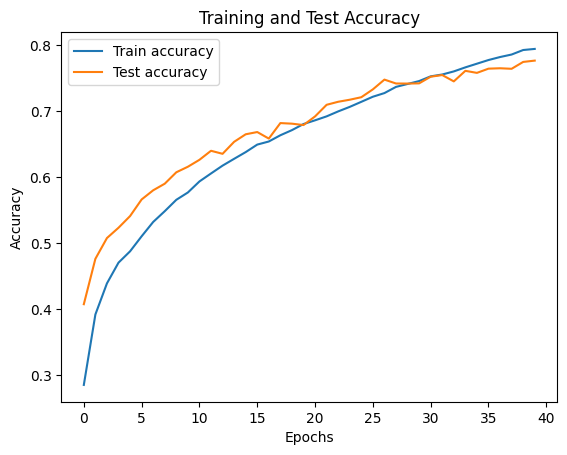

In [99]:
plt.plot(train_accuracies,label="Train accuracy")
plt.plot(test_accuracies,label="Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [100]:
import random

In [101]:
len(test_dataset)

10000

In [102]:
test_dataset[0][0]/2+0.5

tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
  model.eval()
  fig,axes=plt.subplots(grid_size, grid_size, figsize=(9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx=random.randint(0,len(dataset)-1)
      img,true_label=dataset[idx]
      input_tensor=img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output=model(input_tensor)
        _, predicted=torch.max(output.data, 1)
      img=img/2+0.5 #un-normalise our images to be able to plot then with matplotlib
      npimg=img.cpu().numpy()
      axes[i,j].imshow(np.transpose(npimg,(1,2,0)))
      truth=classes[true_label]==classes[predicted.item()]
      if truth:
        color="g"
      else:
        color="r"
      axes[i,j].set_title(f"Truth: {classes[true_label]}\n, Predicted:{classes[predicted.item()]}",fontsize=10,c=color)
      axes[i,j].axis("off")
  plt.tight_layout()
  plt.show()

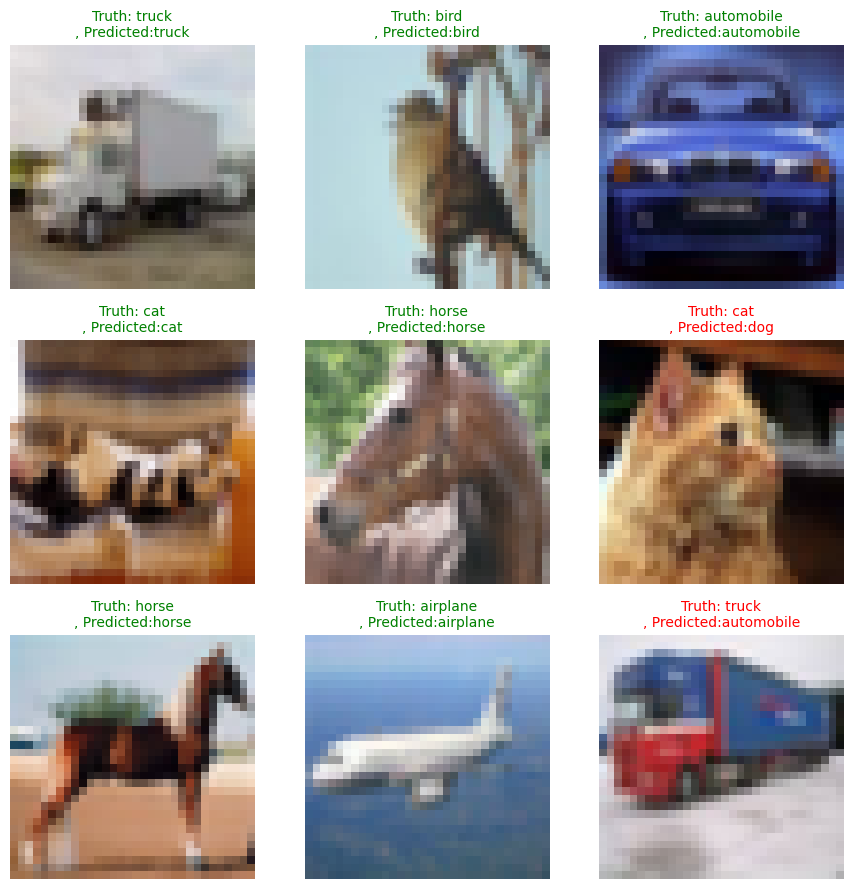

In [104]:
predict_and_plot_grid(model,
                      test_dataset,
                      classes=train_dataset.classes,
                      grid_size=3)